# Python preprocessing

-----------------------------------------------------------------

# Prepocessing for sleep data

In [110]:
# import the library
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")
import datetime


In [111]:
# import the data
SLEEP_PATH = "data/sleep/sleep-export.csv"
sleep =pd.read_csv(SLEEP_PATH,header=0,usecols=[1,2,3,5,11,12])

In [112]:
sleep.head(3)

,Tz,From,To,Hours,Cycles,DeepSleep
0,Europe/Bucharest,30. 03. 2021 2:33,30. 03. 2021 9:23,6.830,12,0.56626505
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Tz,From,To,Hours,Cycles,DeepSleep


In [113]:
#suppress the header of the rows
#mask 1
mask1=sleep[sleep["Tz"]!="Tz"]
#mask 2
sleep_df = mask1[~mask1["Tz"].isna()]

In [114]:
sleep_df.head(3)

,Tz,From,To,Hours,Cycles,DeepSleep
0,Europe/Bucharest,30. 03. 2021 2:33,30. 03. 2021 9:23,6.830,12,0.56626505
3,Etc/GMT-3,30. 03. 2021 0:30,30. 03. 2021 2:12,1.700,0,0.060240965
5,Europe/Bucharest,29. 03. 2021 0:33,29. 03. 2021 9:05,8.540,14,0.5825243


In [115]:
#  get into time format
sleep_df["bed_date"]=pd.to_datetime(sleep_df["From"],format="%d. %m. %Y %H:%M").dt.date
sleep_df["bed_time"]=pd.to_datetime(sleep_df["From"],format="%d. %m. %Y %H:%M").dt.time
sleep_df["waking_up_date"]=pd.to_datetime(sleep_df["To"],format="%d. %m. %Y %H:%M").dt.date
sleep_df["waking_up_time"]=pd.to_datetime(sleep_df["To"],format="%d. %m. %Y %H:%M").dt.time

<ipython-input-115-c5bd1cc1a124>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_df["bed_date"]=pd.to_datetime(sleep_df["From"],format="%d. %m. %Y %H:%M").dt.date
<ipython-input-115-c5bd1cc1a124>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_df["bed_time"]=pd.to_datetime(sleep_df["From"],format="%d. %m. %Y %H:%M").dt.time
<ipython-input-115-c5bd1cc1a124>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [116]:
# drop the column From and To
sleep_df=sleep_df.drop(columns=["From","To"],axis=1)

In [117]:
#reset index and drop them 
sleep_df=sleep_df.reset_index().drop(["index"],axis=1)

In [118]:
# we take the day were we wake up always the same because problem with the days were we slept after 00:00 and then we assume 
# that the day of the activity will be the day before the day we wake up (Note that we will not consider small Cylcle sleep as nap.)

sleep_df["Activity date"]=sleep_df["waking_up_date"]-datetime.timedelta(days=1)

In [119]:
# hypothesis we didn't take into count too small number of cycle because it can be see as nap or misleading datas

cycle0 = sleep_df.loc[sleep_df["Cycles"]=='0']
sleep_df2=sleep_df.drop(cycle0.index)
cycle1 = sleep_df2.loc[sleep_df["Cycles"]=='1']
sleep_df2=sleep_df2.drop(cycle1.index)
cycle_1 = sleep_df2.loc[sleep_df2["Cycles"]=='-1']
sleep_df2=sleep_df2.drop(cycle_1.index)

# string to float

sleep_df2['Hours']=sleep_df2['Hours'].astype(float)
sleep_df2['Cycles']=sleep_df2['Cycles'].astype(float)
sleep_df2['DeepSleep']=sleep_df2['DeepSleep'].astype(float)



# Preprocessing for activity data

In [120]:
#load activity as one table

activities = pd.read_csv("data/strava/activities_with_gpx.csv",usecols=['Activity Date', 'Activity Name', 'Activity Type', 'Distance', 'Relative Effort', 'Average Heart Rate', 
     'Calories','Filename','Average Speed'])

# set the format 

activities["Activity date"]=pd.to_datetime(activities["Activity Date"],dayfirst=True).dt.date
activities["Activity time"]=pd.to_datetime(activities["Activity Date"],dayfirst=True).dt.time

# drop the initial string date

activities=activities.drop(columns=["Activity Date"],axis=1)

In [121]:
# As we can have done more activity I use this line of code to take in count only 1 activity by days 

number_activity_day=activities.groupby(["Activity date"]).count().rename({"Activity Name": "num_activity"},axis=1).reset_index().iloc[:,:2]
print(number_activity_day.shape)

(228, 2)


In [122]:
activities.head(3)

,Activity Name,Activity Type,Distance,Relative Effort,Filename,Average Speed,Average Heart Rate,Calories,Activity date,Activity time
0,Hilton Garden Inn Cupertino - Aloha Mobile Vil...,Run,5.68,102.0,activities/3823237250.fit.gz,2.986698,172.234955,425.0,2020-06-06,00:18:52
1,Hilton Garden Inn Cupertino - Aloha Mobile Vil...,Run,5.78,95.0,activities/3823237266.fit.gz,2.528903,165.807648,439.0,2020-06-03,14:10:57
2,Hilton Garden Inn Cupertino - Aloha Mobile Vil...,Run,5.37,106.0,activities/3823237279.fit.gz,2.929553,174.295471,418.0,2020-06-03,03:07:39


In [123]:
# merge both data set sleep and activity 

sport_sleep_df=number_activity_day.merge(sleep_df2,on=['Activity date'])
sport_sleep_df.shape

(77, 10)

In [124]:
# drop a few columns

sport_sleep_df["num_activity"]=sport_sleep_df["num_activity"].astype(float)
sport_sleep_df=sport_sleep_df.drop(['waking_up_time','waking_up_date','bed_time','bed_date','Tz','num_activity'],axis=1)

In [125]:
# set a new columns with only ones which means that a activity was made during this day 

df_new_column = pd.DataFrame(np.ones(77), columns=['activity'] )
sport_sleep_df = pd.concat([sport_sleep_df,df_new_column], axis=1)

In [126]:
print(sport_sleep_df.shape)
sport_sleep_df.head(3)

(77, 5)


,Activity date,Hours,Cycles,DeepSleep,activity
0,2020-11-30,5.00,2.0,0.375451,1.0
1,2020-12-01,8.33,15.0,0.465347,1.0
2,2020-12-02,8.16,13.0,0.515151,1.0


In [127]:
# for comparing on the same number of night we take a samples of the night

sport_sleep_df_43_night=sport_sleep_df.sample(43)
sport_sleep_df_43_night.shape

(43, 5)

In [128]:
sport_sleep_df_43_night.head(3)

,Activity date,Hours,Cycles,DeepSleep,activity
76,2021-03-23,8.18,3.0,0.321168,1.0
23,2020-12-26,8.20,13.0,0.565657,1.0
57,2021-02-07,8.86,16.0,0.542056,1.0


In [129]:
# take all the day with an activity
day_with_activity=sport_sleep_df["Activity date"].unique()

# get the day without activity 
no_sport_sleep_df=sleep_df2.loc[~sleep_df2['Activity date'].isin(day_with_activity)]
no_sport_sleep_df=no_sport_sleep_df.drop(['waking_up_time','waking_up_date','bed_time','bed_date','Tz'],axis=1)

In [130]:
no_sport_sleep_df.head(3)

,Hours,Cycles,DeepSleep,Activity date
0,6.83,12.0,0.566265,2021-03-29
2,8.54,14.0,0.582524,2021-03-28
3,7.19,15.0,0.627907,2021-03-27


In [131]:
# drop the index 
no_sport_sleep_df=no_sport_sleep_df.reset_index().drop(['index'],axis=1)

In [132]:
#same as before but now a columns with only zeros as no activity was made 

df_new_column = pd.DataFrame(np.zeros(43), columns=['activity'] )
no_sport_sleep_df = pd.concat([no_sport_sleep_df,df_new_column], axis=1)

In [133]:
print(no_sport_sleep_df.shape)
no_sport_sleep_df.head(3)

(43, 5)


,Hours,Cycles,DeepSleep,Activity date,activity
0,6.83,12.0,0.566265,2021-03-29,0.0
1,8.54,14.0,0.582524,2021-03-28,0.0
2,7.19,15.0,0.627907,2021-03-27,0.0


In [134]:
#make one data set

nights_recorded_activity_vs_no_activity=no_sport_sleep_df.append(sport_sleep_df_43_night,ignore_index=True)
nights_recorded_activity_vs_no_activity.sample(3)


,Hours,Cycles,DeepSleep,Activity date,activity
30,8.53,3.0,0.466667,2021-01-28,0.0
42,7.07,2.0,0.413437,2020-11-04,0.0
47,8.16,13.0,0.515151,2020-12-02,1.0


### Create the dataset for Activity vs No activity

In [135]:
nights_recorded_activity_vs_no_activity.to_csv('nights_recorded_activity_vs_no_activity_balanced.csv')

------------------------------------------------------------------------

# Preprocessing for Cycle / Deep sleep vs Calories analysis

In [136]:

# merge both data set sleep and activity 

calories=activities.groupby(["Activity date"]).sum().rename({"Activity Name": "num_activity"},axis=1).reset_index()\
.drop(['Relative Effort','Average Speed','Average Heart Rate'],axis=1)
sport_sleep_df_cal=calories.merge(sleep_df2,on=['Activity date'])

# drop a few columns

sport_sleep_df_cal["Calories"]=sport_sleep_df_cal["Calories"].astype(float)
sport_sleep_df_cal=sport_sleep_df_cal.drop(['waking_up_time','waking_up_date','bed_time','bed_date','Tz'],axis=1)

In [137]:
calories.head(3)

,Activity date,Calories
0,2019-11-16,916.590088
1,2020-03-04,662.000000
2,2020-03-05,679.000000


In [138]:
sport_sleep_df_cal.head(3)

,Activity date,Calories,Hours,Cycles,DeepSleep
0,2020-11-30,422.0,5.00,2.0,0.375451
1,2020-12-01,592.0,8.33,15.0,0.465347
2,2020-12-02,512.0,8.16,13.0,0.515151


### Create the dataset for Calories ( Hours,Cycles,DeepSleep)

In [139]:
sport_sleep_df_cal.to_csv('calories.csv')

----------------------------------------------------

# Preprocessing for Hours/ Cycle / Deep sleep vs Moving time 

In [140]:
#load activity as one table
activities = pd.read_csv("data/strava/activities_with_gpx.csv",usecols=['Activity Date', 'Moving Time'])

# set the format 

activities["Activity date"]=pd.to_datetime(activities["Activity Date"],dayfirst=True).dt.date

# drop the initial string date
activities=activities.drop(columns=["Activity Date"],axis=1)
activities['Moving Time']=activities['Moving Time'].astype(float)

In [141]:
# get the number of second of sport made in a day 
moving_time=activities.groupby(['Activity date']).sum().reset_index()

In [142]:
print(moving_time.shape)
moving_time.head(3)

(228, 2)


,Activity date,Moving Time
0,2019-11-16,11956.0
1,2020-03-04,4298.0
2,2020-03-05,4631.0


In [143]:
# We reuse the sleep_df2 data set made in the part one of the preprocessing for Sleep Data 
sleep_df2.head(3)

,Tz,Hours,Cycles,DeepSleep,bed_date,bed_time,waking_up_date,waking_up_time,Activity date
0,Europe/Bucharest,6.83,12.0,0.566265,2021-03-30,02:33:00,2021-03-30,09:23:00,2021-03-29
2,Europe/Bucharest,8.54,14.0,0.582524,2021-03-29,00:33:00,2021-03-29,09:05:00,2021-03-28
3,Europe/Bucharest,7.19,15.0,0.627907,2021-03-28,00:43:00,2021-03-28,08:54:00,2021-03-27


In [144]:
sleep_quality=sleep_df2.drop(['Tz','bed_date','bed_time','bed_time','waking_up_time','waking_up_date'],axis=1)

In [145]:
sleep_night_recorded=sleep_quality['Activity date'].unique()

In [146]:
# only the record night after a activity 
nights_after_activity=moving_time.loc[moving_time['Activity date'].isin(sleep_night_recorded)]
print(nights_after_activity.shape)
nights_after_activity.head(3)


(77, 2)


,Activity date,Moving Time
145,2020-11-30,3025.0
146,2020-12-01,2939.0
147,2020-12-02,3251.0


In [147]:
# merging activity and sleep feature and keeping only the Moving time 
nights_recorded=sleep_df2.merge(nights_after_activity,on=['Activity date']).drop(['Tz','bed_date','bed_time','bed_time','waking_up_time','waking_up_date'],axis=1)

In [148]:
nights_recorded.head(3)

,Hours,Cycles,DeepSleep,Activity date,Moving Time
0,8.18,3.0,0.321168,2021-03-23,3988.0
1,8.60,16.0,0.490385,2021-03-22,1983.0
2,8.71,17.0,0.650943,2021-03-09,1923.0


In [149]:
# adding the day/night without activity 
no_sport_sleep_df=no_sport_sleep_df.rename({'activity':'Moving Time'},axis=1)
no_sport_sleep_df.head(3)

,Hours,Cycles,DeepSleep,Activity date,Moving Time
0,6.83,12.0,0.566265,2021-03-29,0.0
1,8.54,14.0,0.582524,2021-03-28,0.0
2,7.19,15.0,0.627907,2021-03-27,0.0


In [150]:
# create one data set
nights_recorded=no_sport_sleep_df.append(nights_recorded,ignore_index=True)

In [151]:
nights_recorded.head(3)

,Hours,Cycles,DeepSleep,Activity date,Moving Time
0,6.83,12.0,0.566265,2021-03-29,0.0
1,8.54,14.0,0.582524,2021-03-28,0.0
2,7.19,15.0,0.627907,2021-03-27,0.0


### Create the dataset for Moving times ( Hours,Cycles,DeepSleep)

In [152]:
nights_recorded.to_csv('df_sleep_analysis_movingtime.csv')

--------------------------------------------------------------------------------------

# Average speed

In [153]:
speed = pd.read_csv("data/strava/activities_with_gpx.csv",usecols=['Activity Type', 'Average Speed'])

In [154]:
speed_grb=speed.groupby(['Activity Type']).mean().drop(['Weight Training','Workout','E-Bike Ride','Virtual Ride'],axis=0)

In [155]:
speed_grb.head(3)
# en mettre par seconde selon strava https://developers.strava.com/docs/reference/#api-models-SummaryActivity sous summary activity

,Average Speed
Activity Type,
Hike,1.158969
Ride,4.397185
Run,2.832024


In [156]:
# in Km/hr
speed_grb.head(3)*60*60/1000

,Average Speed
Activity Type,
Hike,4.172289
Ride,15.829864
Run,10.195286


-------------------------------------------------------------

# Motivation Study 

In [157]:
#load activity as one table
activities = pd.read_csv("data/strava/activities_with_gpx.csv",usecols=['Activity Date', 'Activity Name', 'Activity Type','Moving Time'])

# set the format 

activities["activity_full_date"]=pd.to_datetime(activities["Activity Date"],dayfirst=True)
activities["Activity time"]=pd.to_datetime(activities["Activity Date"],dayfirst=True).dt.time

# drop the initial string date
activities=activities.drop(columns=["Activity Date"],axis=1)

In [158]:
np.sort(np.array(activities["activity_full_date"].dt.date))[:2]

array([datetime.date(2019, 11, 16), datetime.date(2020, 3, 4)],
      dtype=object)

In [159]:
motivation_by_type=activities.groupby([pd.Grouper(key="activity_full_date",freq='1M',origin='2020-03-04'),"Activity Type"]).sum()
pd_motivationby_type=motivation_by_type.unstack().replace(np.nan, 0)
pd_motivationby_type.head(3)

Moving Time                                               \
Activity Type      E-Bike Ride Hike     Ride      Run     Swim Virtual Ride   
activity_full_date                                                            
2019-11-30                 0.0  0.0  11956.0      0.0      0.0          0.0   
2020-03-31                 0.0  0.0  22080.0   9600.0  15612.0       4837.0   
2020-04-30                 0.0  0.0  32389.0  23898.0      0.0          0.0   

                                                      
Activity Type          Walk Weight Training  Workout  
activity_full_date                                    
2019-11-30              0.0             0.0      0.0  
2020-03-31          13976.0         21473.0  19842.0  
2020-04-30           9718.0             0.0  14273.0

In [160]:
# putting out the movingtime label and taking only the columns 
legend=[]
for i in pd_motivationby_type.columns:
    legend.append(i[1])
legend
pd_motivationby_type.columns=legend
pd_motivationby_type

,E-Bike Ride,Hike,Ride,Run,Swim,Virtual Ride,Walk,Weight Training,Workout
activity_full_date,,,,,,,,,
2019-11-30,0.0,0.0,11956.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-31,0.0,0.0,22080.0,9600.0,15612.0,4837.0,13976.0,21473.0,19842.0
2020-04-30,0.0,0.0,32389.0,23898.0,0.0,0.0,9718.0,0.0,14273.0
2020-05-31,0.0,0.0,10880.0,24720.0,0.0,0.0,13928.0,0.0,0.0
2020-06-30,0.0,10524.0,20126.0,41439.0,8328.0,0.0,5837.0,0.0,0.0
2020-07-31,0.0,45333.0,24101.0,29827.0,6430.0,0.0,0.0,0.0,11901.0
2020-08-31,0.0,21557.0,0.0,12838.0,530.0,0.0,0.0,0.0,0.0
2020-09-30,0.0,0.0,19055.0,9079.0,10104.0,0.0,2209.0,0.0,0.0
2020-10-31,0.0,0.0,11996.0,11559.0,1969.0,0.0,0.0,0.0,0.0


In [161]:
# drop the data from 2019
pd_motivationby_type_=pd_motivationby_type.iloc[1:,:]


In [162]:
# drop virtual Ride because its too small
pd_motivationby_type_=pd_motivationby_type_.drop(["Virtual Ride"],axis=1)
pd_motivationby_type_

,E-Bike Ride,Hike,Ride,Run,Swim,Walk,Weight Training,Workout
activity_full_date,,,,,,,,
2020-03-31,0.0,0.0,22080.0,9600.0,15612.0,13976.0,21473.0,19842.0
2020-04-30,0.0,0.0,32389.0,23898.0,0.0,9718.0,0.0,14273.0
2020-05-31,0.0,0.0,10880.0,24720.0,0.0,13928.0,0.0,0.0
2020-06-30,0.0,10524.0,20126.0,41439.0,8328.0,5837.0,0.0,0.0
2020-07-31,0.0,45333.0,24101.0,29827.0,6430.0,0.0,0.0,11901.0
2020-08-31,0.0,21557.0,0.0,12838.0,530.0,0.0,0.0,0.0
2020-09-30,0.0,0.0,19055.0,9079.0,10104.0,2209.0,0.0,0.0
2020-10-31,0.0,0.0,11996.0,11559.0,1969.0,0.0,0.0,0.0
2020-11-30,0.0,0.0,3025.0,1917.0,2094.0,0.0,0.0,0.0


In [163]:
# get the sum of each ride
np.sum(pd_motivationby_type_,axis=0)

E-Bike Ride          6591.0
Hike                87246.0
Ride               255933.0
Run                283029.0
Swim                45067.0
Walk                47055.0
Weight Training     21473.0
Workout             46016.0
dtype: float64

In [164]:
# shifting columns name 
pd_motivationby_type_ = pd_motivationby_type_[['E-Bike Ride','Weight Training','Swim','Workout','Walk','Hike','Ride','Run']]

In [165]:
# rename them for a better view on the graph 
pd_motivationby_type_=pd_motivationby_type_.rename({"E-Bike Ride":"E-Bike","Weight Training":"Weight_Training","Ride":"Bike"},axis=1)


In [166]:
#hr
pd_motivationby_type_HR=pd_motivationby_type_/60/60

### Create the dataset for Motivation to be able to make a stacked graph in D3.

In [167]:
pd_motivationby_type_HR.to_csv('motivation_by_type.csv')

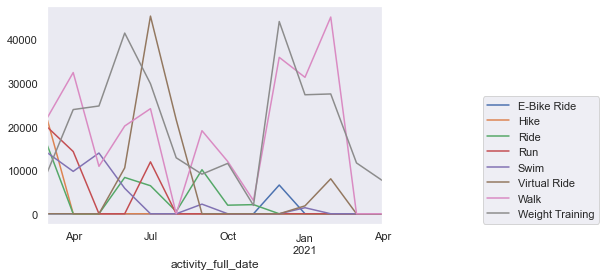

In [168]:
pd_motivationby_type_.plot()
plt.legend(legend,loc=(1.3,0))

In [169]:
# quick view on how is it if stacked
motivation_test=activities.groupby([pd.Grouper(key="activity_full_date",freq='1M',origin='2020-03-04')]).sum()
motivation_test=motivation_test.drop(motivation_test.index[:5],axis=0)
# in hr
motivation_test=motivation_test/3600

<AxesSubplot:xlabel='activity_full_date'>

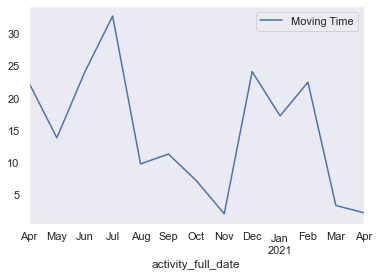

In [170]:
motivation_test.plot()

------------------------------------

# Athletes Type

In [185]:
#summer,spring ---> 
summer_spring=pd_motivationby_type.iloc[2:8,:]

#fall,winter --->
fall_winter=pd_motivationby_type.drop(summer_spring.index,axis=0)

## Summer and Spring

In [186]:
summer_spring

,E-Bike Ride,Hike,Ride,Run,Swim,Virtual Ride,Walk,Weight Training,Workout
activity_full_date,,,,,,,,,
2020-04-30,0.0,0.0,32389.0,23898.0,0.0,0.0,9718.0,0.0,14273.0
2020-05-31,0.0,0.0,10880.0,24720.0,0.0,0.0,13928.0,0.0,0.0
2020-06-30,0.0,10524.0,20126.0,41439.0,8328.0,0.0,5837.0,0.0,0.0
2020-07-31,0.0,45333.0,24101.0,29827.0,6430.0,0.0,0.0,0.0,11901.0
2020-08-31,0.0,21557.0,0.0,12838.0,530.0,0.0,0.0,0.0,0.0
2020-09-30,0.0,0.0,19055.0,9079.0,10104.0,0.0,2209.0,0.0,0.0


In [187]:
sum_by_type_summer=np.sum(summer_spring,axis=0)
sum_by_type_summer

E-Bike Ride             0.0
Hike                77414.0
Ride               106551.0
Run                141801.0
Swim                25392.0
Virtual Ride            0.0
Walk                31692.0
Weight Training         0.0
Workout             26174.0
dtype: float64

**In %**

In [182]:
sum_by_type_summer/np.sum(sum_by_type_summer)

E-Bike Ride        0.000000
Hike               0.189265
Ride               0.260501
Run                0.346681
Swim               0.062079
Virtual Ride       0.000000
Walk               0.077482
Weight Training    0.000000
Workout            0.063991
dtype: float64

## Fall and Winter

In [183]:
sum_by_type_winter=np.sum(fall_winter,axis=0)
sum_by_type_winter

E-Bike Ride          6591.0
Hike                 9832.0
Ride               161338.0
Run                141228.0
Swim                19675.0
Virtual Ride         4837.0
Walk                15363.0
Weight Training     21473.0
Workout             19842.0
dtype: float64

In [184]:
sum_by_type_winter/np.sum(sum_by_type_winter)

E-Bike Ride        0.016470
Hike               0.024569
Ride               0.403165
Run                0.352912
Swim               0.049165
Virtual Ride       0.012087
Walk               0.038390
Weight Training    0.053658
Workout            0.049583
dtype: float64

----------------------------------------------------